In [141]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

def create_segmented_mode_basis(segments, num_modes=3):
    
    mode_basis = []
    def func(grid):
        x = grid.x
        y = grid.y
        for segment in segments:
            segment_diameter = max(x[segment>0].ptp(), y[segment>0].ptp())
            xc = x - np.sum(segment * x) / np.sum(segment)
            yc = y - np.sum(segment * y) / np.sum(segment)
            segment_grid = CartesianGrid(UnstructuredCoords((xc[segment>0], yc[segment>0])))
            
            segment_zernike_modes = make_zernike_basis(num_modes, segment_diameter, segment_grid) 
            orthogonal_modes = segment_zernike_modes#.orthogonalized
            
            segment_modes = grid.zeros((num_modes,))
            segment_modes[:, segment>0] = orthogonal_modes
            # Orthogonalize makes the piston mode negative. Let's make it positive.
            segment_modes[0] *= np.sign(np.median(orthogonal_modes[0]))

            sparse_segment_modes = sparse.csr_matrix(segment_modes)
            sparse_segment_modes.eliminate_zeros()
            mode_basis.append(sparse_segment_modes)

        return ModeBasis(mode_basis)

    return func

In [142]:
npix = 2048
dia = 1 # 27
grid = make_pupil_grid(npix, dia)

aperture_func, seg_funcs = make_gmt_aperture(return_segments=True,normalized=True)
segments = Field([seg(grid) for seg in seg_funcs], grid)

segmented_modes = create_segmented_mode_basis(segments, num_modes=11)(grid)

In [143]:
coeffs = np.random.random(segmented_modes.num_modes)
mode_eval = segmented_modes.linear_combination(coeffs)
mode_array = mode_eval.sum(axis=0).reshape([npix,npix])#.toarray()
mask = np.zeros_like(mode_array)
mask[mode_array != 0] = 1

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_28704\4013520008.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(mode_array/mask)


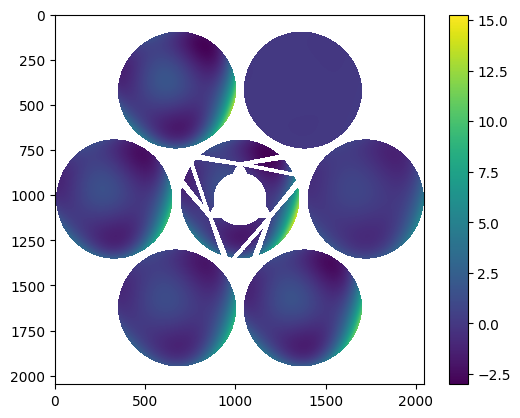

In [144]:
plt.imshow(mode_array/mask)
plt.colorbar()

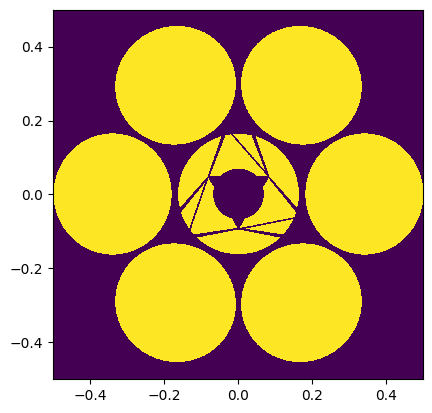

In [145]:
# create a perfect coronagraph for this aperture
imshow_field(aperture_func(grid))

In [147]:
al2o3 = SurfaceAberration(grid,ptv=2*0.08e-9,diameter=1)

c:\Users\UASAL-OPTICS\anaconda3\envs\gsmts\lib\site-packages\hcipy\optics\aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_28704\1582744084.py:3: RuntimeWarning: invalid value encountered in divide
  imshow_field(wf_ab.phase/wf.intensity,cmap='inferno')


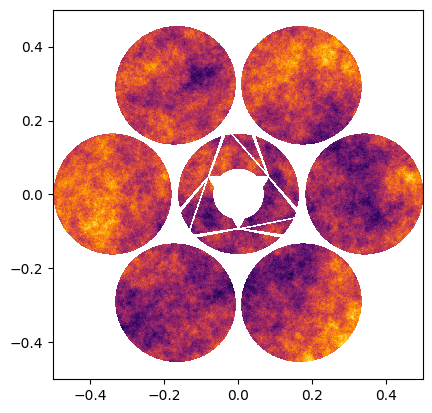

In [148]:
wf = Wavefront(aperture_func(grid),1)
wf_ab = al2o3(wf)
imshow_field(wf_ab.phase/wf.intensity,cmap='inferno')

C:\Users\UASAL-OPTICS\AppData\Local\Temp\ipykernel_28704\1723605013.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(al2o3_layer/wf.intensity.shaped*1e9,interpolation='none',cmap='magma')


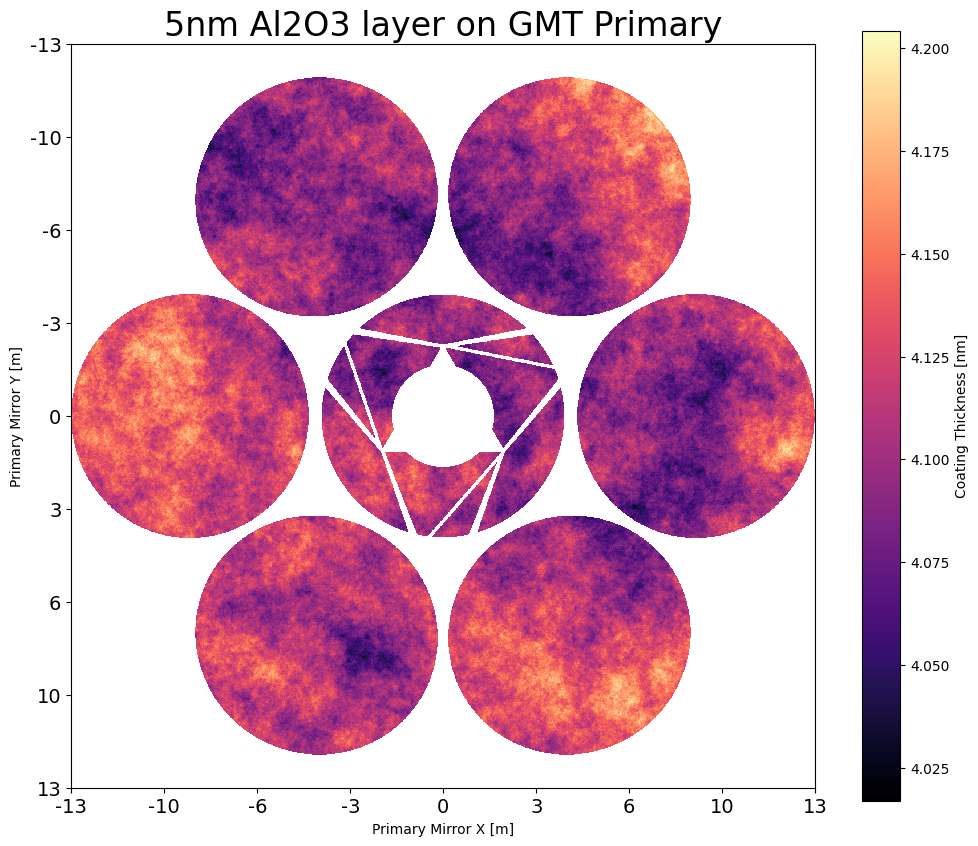

In [152]:
al2o3_layer = wf_ab.phase.shaped/10
al2o3_layer += 4.11e-9

step = int(2048/8)
ticks = np.arange(0,2048+step,step)
tickstr = np.linspace(-27/2,27/2,len(ticks))
tickstr = [int(i) for i in tickstr]
plt.figure(figsize=[12,10])
plt.title('5nm Al2O3 layer on GMT Primary',fontsize=24)
plt.imshow(al2o3_layer/wf.intensity.shaped*1e9,interpolation='none',cmap='magma')
plt.colorbar(label='Coating Thickness [nm]')
plt.xticks(ticks,tickstr,fontsize=14)
plt.yticks(ticks,tickstr,fontsize=14)
plt.xlabel('Primary Mirror X [m]')
plt.ylabel('Primary Mirror Y [m]')
plt.show()

In [108]:
# create a propagator
focal_grid = make_focal_grid(8,12)
prop = FraunhoferPropagator(grid,focal_grid)

# create a coronagraph
coro = PerfectCoronagraph(aperture_func(grid),order=2)

# try a broadband coronagrpahic psf
bandwidth = 0.2

focal_total = 0
for wlen in np.linspace(1 - bandwidth / 2., 1 + bandwidth / 2., 11):
    wavefront = Wavefront(aperture_func(grid), wlen)
    lyot = coro.forward(wavefront)
    focal_total += prop(lyot).intensity

In [110]:
from matplotlib.colors import SymLogNorm
imshow_field((focal_total),norm=SymLogNorm())

TypeError: missing a required argument: 'linthresh'

In [104]:
coro_4 = PerfectCoronagraph(aperture_func(grid),order=2)

In [95]:
lyot = coro_4.forward(Wavefront(aperture_func(grid)))

In [70]:
help(PerfectCoronagraph)

Help on class PerfectCoronagraph in module hcipy.coronagraphy.perfect_coronagraph:

class PerfectCoronagraph(hcipy.optics.optical_element.OpticalElement)
 |  PerfectCoronagraph(aperture, order=2, coeffs=None)
 |  
 |  A perfect coronagraph for a certain aperture and order.
 |  
 |  These type of coronagraphs suppress all light for a flat wavefront. The incoming complex
 |  amplitude :math:`A` is modified as follows (following [Cavarroc2006]_):
 |  
 |  .. math::
 |          \overline{A} = A - \Pi \sqrt{S}
 |  
 |  where :math:`\overline{A}` is the resulting complex ampliutude, :math:`\Pi` is the telescope
 |  pupil, and :math:`S` is the Strehl ratio of the incoming wavefront.
 |  
 |  Higher orders are added by fitting higher-order electric field modes to the incoming
 |  wavefront and subtracting those, following [Guyon2006]_.
 |  
 |  .. [Cavarroc2006] Celine Cavarroc et al. "Fundamental limitations on Earth-like planet detection with
 |          extremely large telescopes." Astronom